## 2.4 清理数据

In [26]:
require(zoo)
require(data.table)

In [27]:
unemp <- fread("../../demo_code/Ch02/data/UNRATE.csv")
unemp[, DATE := as.Date(DATE, format = "%Y-%m-%d")]
setkey(unemp, DATE)

In [28]:
unemp

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8


In [29]:
# 生成一个数据随机缺失的数据集
rand.unemp.idx <- sample(1:nrow(unemp), .1*nrow(unemp)) # 10%的数据缺失
rand.unemp     <- unemp[-rand.unemp.idx]    # 有随机的缺失, 删除这些随机选中的行

In [30]:
# 生成一个数据集
# 在该数据集中，失业率高的数据更有可能缺失
high.unemp.idx <- which(unemp$UNRATE > 8)
num.to.select  <- .2 * length(high.unemp.idx)
high.unemp.idx <- sample(high.unemp.idx, )
bias.unemp     <- unemp[-high.unemp.idx]        # 会缺失失业率高的月份

## R: data.table
- 具体见[data.table.md](../notes/chap2/R_data_table.md)
- 具体见[data.table官方例子](../my_code/data_table.ipynb)
  
- eg:使用`:=运算符` --- **按引用修改数据**


`dt[, new.col := old.col + 7]`: 向data.table添加了一列，且无须将整个data.table复制到一个新对象上，这帮助我们减少了对内存的使用

- 对象索引的列表中, 第一个位置是对行进行修改, 第二个位置([, .....])是对列进行修改

#### data.table 中的 J(...)

- J()：用于精确或近似匹配键值，常用于滚动连接或基于键的操作中。
- list()：创建一个列表结构，通常用于组合多个列或返回一组值，广泛应用于聚合操作。
- .()：是 data.table 中的简写版本，功能与 list() 相似，用于返回多个列或表达式的结果

In [31]:
all.dates <- seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1),    # from DATE的开始到结尾
                 by = "months")
# 如果 all.dates 中的日期不存在于原数据表中，它会触发 roll 机制来处理缺失值
rand.unemp = rand.unemp[J(all.dates), roll=0]       # J(): 用于进行键匹配的函数
bias.unemp = bias.unemp[J(all.dates), roll=0]
rand.unemp[, rpt := is.na(UNRATE)]
# 我们标记了缺失的数据，以便进行绘制

### 缺失值的处理方法

- 前向填充法
- 移动平均法
- 插值法


滑动连接roll参数:

- roll = TRUE: 当无法找到精确匹配时，返回最接近的匹配值。如果 donations 中的日期大于 publicity 中的日期，则会选择 publicity 中小于等于当前日期的最大日期进行匹配。
- roll = 0: 不进行任何近似匹配。如果无法找到精确匹配，则返回 NA。
- roll = Inf 或 roll = -Inf: 分别表示返回向前或向后最接近的匹配值

In [32]:
# 滑动连接

# 滑动连接能够智能地处理时间戳, 尽管表与表之间的时间戳不会精准的匹配

donations <- data.table(
    amt = c(99, 100, 5, 15, 11, 1200),
    dt = as.Date(c("2019-2-27", "2019-3-2", "2019-6-13",
                "2019-8-1", "2019-8-31", "2019-9-15")))
# 我们还有每个宣传活动的日期信息
publicity <- data.table(
        identifier = c("q4q42", "4299hj", "bbg2"),
        dt         = as.Date(c("2019-1-1",
             "2019-4-1",
            "2019-7-1")))


# 为每个data.table设置主键
setkey(publicity, "dt")
setkey(donations, "dt")

publicity[donations, roll = TRUE]       # 在匹配时处理 近似匹配

identifier,dt,amt
<chr>,<date>,<dbl>
q4q42,2019-02-27,99
q4q42,2019-03-02,100
4299hj,2019-06-13,5
bbg2,2019-08-01,15
bbg2,2019-08-31,11
bbg2,2019-09-15,1200


#### 向前填充法

使用缺失值之前的最后一个已知值进行填充

In [33]:
# 注意: := 语法用于对现有列进行修改或者创建新列, 而不是直接使用 =
rand.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]
bias.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]

NULL

NULL

NULL

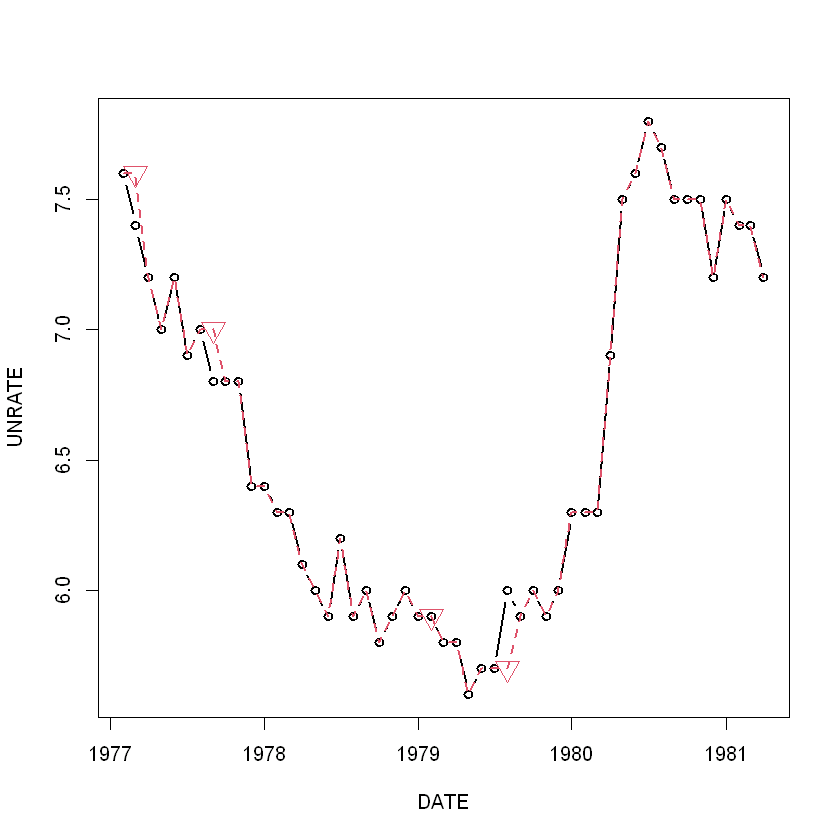

In [34]:
# 绘制平面示例图
unemp[350:400, plot(DATE, UNRATE,
    col = 1, lwd = 2, type = 'b')]

rand.unemp[350:400, lines(DATE, impute.ff,
    col = 2, lwd = 2, lty = 2)]
rand.unemp[350:400][rpt == TRUE, points(DATE, impute.ff, 
    col = 2, pch = 6, cex = 2)]

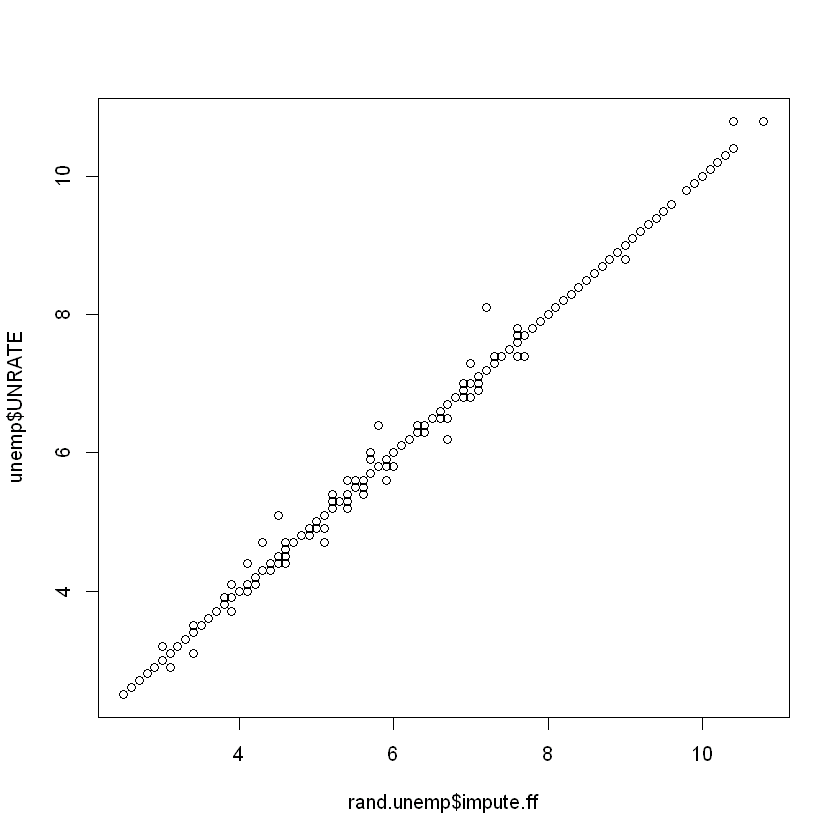

In [35]:
plot(rand.unemp$impute.ff, unemp$UNRATE)

#### 移动平均法

用移动平均数或中位数来估算数据, 与前向填充相似，移动平均法使用过去的值“预测”未来的缺失值

不过，对于移动平均法，你使用的是过去的`多次`输入

- `frollapply(x, n, FUN, ..., fill=NA, align=c("right", "left", "center"))`
    - x: 构建的窗口, 使用NA 来作为占位符 
    - n: 窗口大小 


In [36]:
rand.unemp

DATE,UNRATE,rpt,impute.ff
<date>,<dbl>,<lgl>,<dbl>
1948-01-01,3.4,FALSE,3.4
1948-02-01,3.8,FALSE,3.8
1948-03-01,4.0,FALSE,4.0
1948-04-01,3.9,FALSE,3.9
1948-05-01,3.5,FALSE,3.5
1948-06-01,3.6,FALSE,3.6
1948-07-01,3.6,FALSE,3.6
1948-08-01,3.9,FALSE,3.9
1948-09-01,3.8,FALSE,3.8


In [37]:
# 无前瞻的移动平均

# c(NA, NA, UNRATE): 构建滑动窗口, 由于n = 3, 所以前两个用缺失值作为占位符
# n = 3: 对于每一行，rollapply 会考虑当前行和前两行的数据来进行计算
rand.unemp[, impute.rm.nolookahead := rollapply(c(NA, NA, UNRATE), 3,
        function(x) {           # x[3](窗口中的第三个元素) <==> UNRATE     
             if(!is.na(x[3])) x[3] else mean(x, na.rm = TRUE)    # 如果为na, 则取前两个已知数的平均值
        })]
bias.unemp[, impute.rm.nolookahead := rollapply(c(NA, NA, UNRATE), 3,
        function(x) {
             if(!is.na(x[3])) x[3] else mean(x, na.rm = TRUE)
        })]

In [38]:
rand.unemp

DATE,UNRATE,rpt,impute.ff,impute.rm.nolookahead
<date>,<dbl>,<lgl>,<dbl>,<dbl>
1948-01-01,3.4,FALSE,3.4,3.40
1948-02-01,3.8,FALSE,3.8,3.80
1948-03-01,4.0,FALSE,4.0,4.00
1948-04-01,3.9,FALSE,3.9,3.90
1948-05-01,3.5,FALSE,3.5,3.50
1948-06-01,3.6,FALSE,3.6,3.60
1948-07-01,3.6,FALSE,3.6,3.60
1948-08-01,3.9,FALSE,3.9,3.90
1948-09-01,3.8,FALSE,3.8,3.80


In [39]:
# 有前瞻的移动平均

rand.unemp[, impute.rm.lookahead := rollapply(c(NA, UNRATE, NA), 3,
        function(x) {           # x[3](窗口中的第三个元素) <==> UNRATE     
             if(!is.na(x[2])) x[2] else mean(x, na.rm = TRUE)    # 如果为na, 则取前两个已知数的平均值
        })]
bias.unemp[, impute.rm.lookahead := rollapply(c(NA, UNRATE, NA), 3,
        function(x) {
             if(!is.na(x[2])) x[2] else mean(x, na.rm = TRUE)
        })]

NULL

NULL

NULL

NULL

NULL

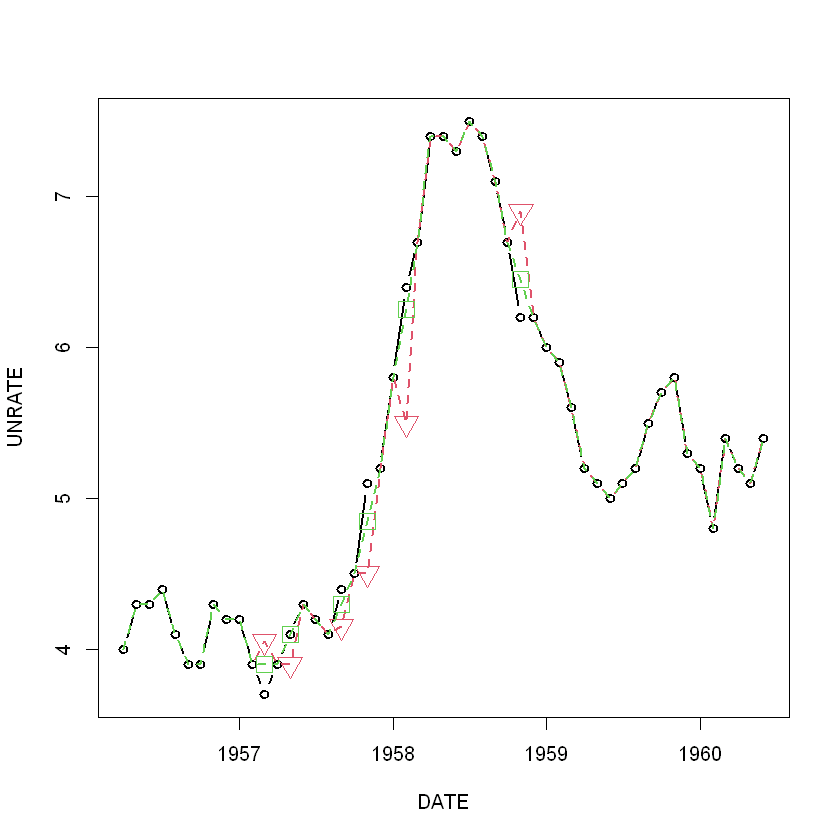

In [40]:
unemp[100:150, plot(DATE, UNRATE,
    col = 1, lwd = 2, type = 'b')]

rand.unemp[100:150, lines(DATE, impute.rm.nolookahead,
    col = 2, lwd = 2, lty = 2)]
rand.unemp[100:150][rpt == TRUE, points(DATE, impute.rm.nolookahead, 
    col = 2, pch = 6, cex = 2)]

rand.unemp[100:150, lines(DATE, impute.rm.lookahead,
    col = 3, lwd = 2, lty = 2)]
rand.unemp[100:150][rpt == TRUE, points(DATE, impute.rm.lookahead, 
    col = 3, pch = 22, cex = 2)]

#### 差值法

线性插值法使缺失数据与已知相邻点线性拟合

In [41]:
# 线性插值法
rand.unemp[, impute.li := na.approx(UNRATE)]
bias.unemp[, impute.li := na.approx(UNRATE)]

# 样条差值法
# Desc: 执行给定数据点的三次（或埃尔米特）样条插值，
# 返回插值得到的点的列表，或者返回一个执行插值的函数。
rand.unemp[, impute.sp := na.spline(UNRATE)]
bias.unemp[, impute.sp := na.spline(UNRATE)]

NULL

NULL

NULL

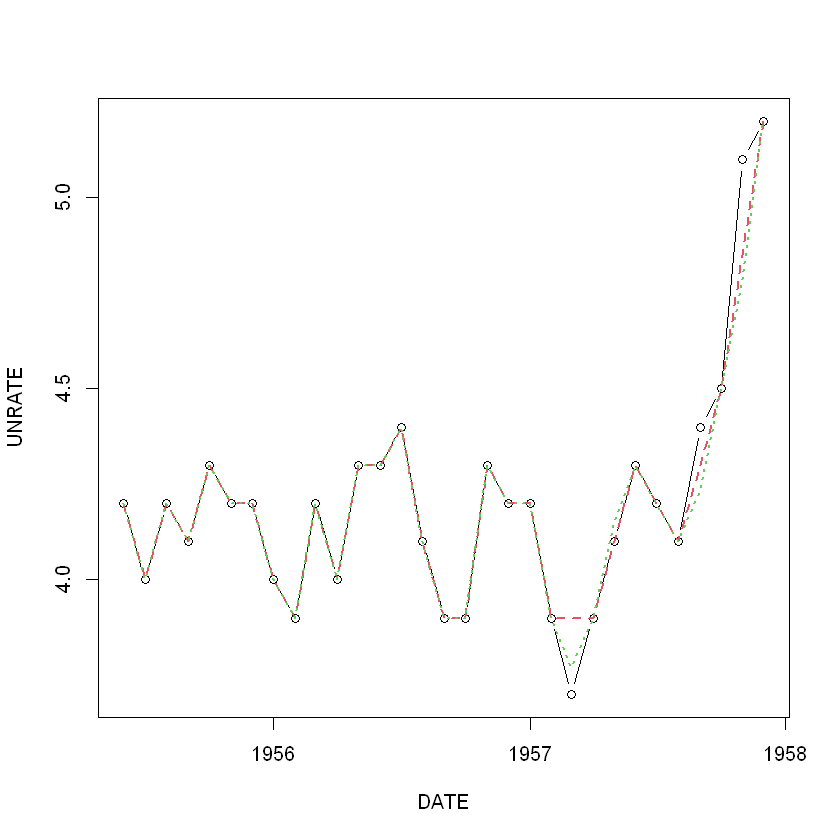

In [42]:
use_index = 90:120

unemp[use_index, plot(DATE, UNRATE, col = 1, type = 'b')]
rand.unemp[use_index, lines(DATE, impute.li, col = 2, lwd = 2, lty = 2)]
rand.unemp[use_index, lines(DATE, impute.sp, col = 3, lwd = 2, lty = 3)]

#### 集中方法的比较

In [43]:
# 计算均方误差
print(sort(unlist(rand.unemp[, lapply(.SD, function(x) mean((x- unemp$UNRATE)^2, na.rm = TRUE)),
                .SDcols = c("impute.ff", "impute.rm.lookahead", "impute.rm.nolookahead", "impute.li","impute.sp")])))

            impute.li   impute.rm.lookahead             impute.sp 
          0.001444346           0.001453627           0.001827149 
            impute.ff impute.rm.nolookahead 
          0.004490521           0.006536861 


In [44]:
print(sort(unlist(bias.unemp[, lapply(.SD, function(x) mean((x- unemp$UNRATE)^2, na.rm = TRUE)),
                .SDcols = c("impute.ff", "impute.rm.lookahead", "impute.rm.nolookahead", "impute.li","impute.sp")])))

  impute.rm.lookahead impute.rm.nolookahead             impute.sp 
          0.001937581           0.005572172           0.023234850 
            impute.li             impute.ff 
          0.216356236           0.231848341 


## 采样

但可以改变数据集合中时间戳出现的频率。提高或降低时间戳的**频率**，被分别称为`上采样`或`下采样`

In [45]:
# 降低数据采集的频率
unemp[seq.int(from = 1, to = nrow(unemp), by = 12)]     # 将频率降到一年一次, 但是输出的结果(UNREATE)为当日的值

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1949-01-01,4.3
1950-01-01,6.5
1951-01-01,3.7
1952-01-01,3.2
1953-01-01,2.9
1954-01-01,4.9
1955-01-01,4.9
1956-01-01,4.0


In [46]:
# 下采样, 并计算均值
unemp[, mean(UNRATE), by = format(DATE, "%Y")]

format,V1
<chr>,<dbl>
1948,3.750000
1949,6.050000
1950,5.208333
1951,3.283333
1952,3.025000
1953,2.925000
1954,5.591667
1955,4.366667
1956,4.125000


In [ ]:
# 上采样: 你添加的是更多的时间标签，而不是更多的信息
all.dates <- seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1),    # from DATE的开始到结尾
                 by = "months")
# 如果 all.dates 中的日期不存在于原数据表中，它会触发 roll 机制来处理缺失值
setkey(rand.unemp, DATE)    # 键匹配并处理缺失值, 需要指定键
rand.unemp = rand.unemp[J(all.dates), roll=0]       # J(): 用于进行键匹配的函数

allday.dates <- seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1),
                 by = "days")
daily.unemployment = unemp[J(allday.dates), roll = TRUE]
daily.unemployment

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-01-02,3.4
1948-01-03,3.4
1948-01-04,3.4
1948-01-05,3.4
1948-01-06,3.4
1948-01-07,3.4
1948-01-08,3.4
1948-01-09,3.4


## 数据平滑



In [60]:
# 以下使用python实现

## 季节性数据

In [112]:
library(zoo)
library(data.table)
AirPassengers <- fread("../../demo_code/Ch02/data/AirPassengers.csv", col.names = c("DATE", "Passengers"))

In [113]:
# 仅提取出来Passenger一列, 并转化为ts(时间序列)类型
AirPassengers_ts <- ts(AirPassengers$Passengers, start = c(1949, 1), frequency = 12)

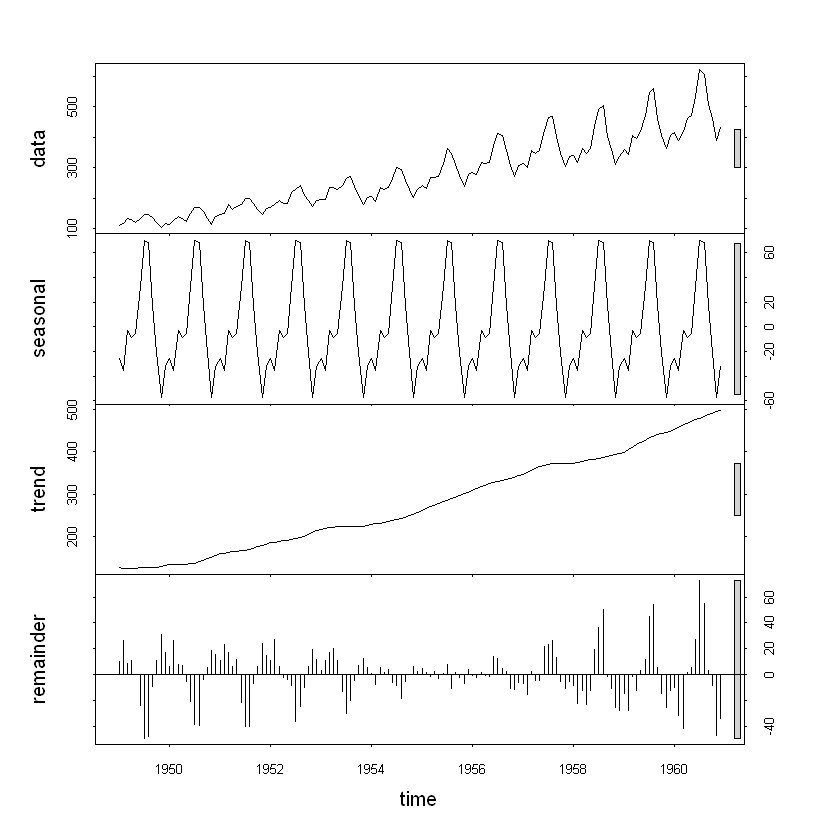

In [ ]:
# 将原始时间序列分解为季节性分量、趋势分量和残差分量
plot(stl(AirPassengers_ts, "periodic"))     # 注意: stl() 只能接受单一的时间序列数据
# 输出图像的右侧有灰色条, 提示不同分量上的纵轴比例不同